In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from collections import Counter # Outlier detection에서 사용

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
train = pd.read_csv('data/train.csv')  # 다운받은 csv를 pandas의 DataFrame 형식으로 불러옵니다.
test = pd.read_csv('data/test.csv')

In [3]:
if (train.columns[0]=='id'):
    train = train.drop(columns=['id'],axis=1) # id 열을 제거해 줍니다.
    
if (test.columns[0]=='id'):
    test = test.drop(columns=['id'],axis=1)

# 2. 이상치 확인, 제거

### 2-1. 전체 무게 < 전복무게 + 껍질의 무게 인 경우(삭제)

In [4]:
train[train["Whole Weight"] < train["Shucked Weight"] + train["Shell Weight"]]

,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
47,I,0.380,0.275,0.095,0.1375,0.0860,0.0585,0.0605,7
382,I,0.455,0.330,0.100,0.3720,0.3580,0.0775,0.1100,8
435,I,0.475,0.365,0.100,0.1315,0.2025,0.0875,0.1230,7
847,I,0.230,0.165,0.060,0.0515,0.0190,0.0145,0.0360,4
1078,I,0.275,0.205,0.070,0.1055,0.4950,0.0190,0.0315,5


In [5]:
train = train[train["Whole Weight"] >= train["Shucked Weight"] + train["Shell Weight"]]

### 2-2. 전복무게 < 내장무게 인 경우 (삭제)

In [6]:
train[train["Shucked Weight"] < train["Viscra Weight"]]

,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
465,M,0.415,0.315,0.125,0.388,0.068,0.09,0.125,12


In [7]:
train = train[train["Shucked Weight"] >= train["Viscra Weight"]]

### 2-3. 이상치 감지

In [8]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Lenght","Diameter","Height", "Whole Weight", "Shucked Weight", "Viscra Weight", "Shell Weight"])

In [9]:
train.loc[Outliers_to_drop] # Show the outliers rows

,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
255,I,0.160,0.120,0.035,0.0210,0.0075,0.0045,0.0050,5
285,I,0.130,0.100,0.030,0.0130,0.0045,0.0030,0.0040,3
463,I,0.110,0.090,0.030,0.0080,0.0025,0.0020,0.0030,3
504,M,0.775,0.630,0.250,2.7795,1.3485,0.7600,0.5780,12
17,M,0.765,0.600,0.220,2.3020,1.0070,0.5090,0.6205,12
511,M,0.740,0.595,0.190,2.3235,1.1495,0.5115,0.5050,11


We detect 6 outliers.

In [10]:
#Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [11]:
train.shape

(1241, 9)

# 4. 변수선택
변수선택을 위해 각 변수의 영향도를 검토해야 합니다.

In [12]:
train.columns

Index(['Gender', 'Lenght', 'Diameter', 'Height', 'Whole Weight',
       'Shucked Weight', 'Viscra Weight', 'Shell Weight', 'Target'],
      dtype='object')

## 수치형 데이터 시각화

이제 수치형 데이터의 통계치를 알아보겠습니다.

pandas의 DataFrame은 describe이라는 메소드를 통해 각 컬럼의 평균값, 최대치, 최소치, 편차 등을 알아보겠습니다.

In [13]:
data_description = train.describe()
data_description

,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
count,1241.000000,1241.000000,1241.000000,1241.000000,1241.000000,1241.000000,1241.000000,1241.000000
mean,0.523969,0.407844,0.139843,0.832280,0.358461,0.181034,0.240624,9.936342
std,0.118065,0.098084,0.038466,0.492616,0.220787,0.109778,0.141398,3.203321
min,0.155000,0.105000,0.040000,0.015500,0.005000,0.003000,0.005000,3.000000
25%,0.445000,0.345000,0.115000,0.444000,0.186000,0.093500,0.130000,8.000000
50%,0.540000,0.420000,0.140000,0.781000,0.326000,0.168500,0.230000,10.000000
75%,0.615000,0.480000,0.165000,1.160000,0.505500,0.256500,0.330000,11.000000
max,0.780000,0.630000,0.250000,2.657000,1.488000,0.541000,1.005000,29.000000


### 데이터 분포 확인하기

숫자로만 봐서는 분포를 가늠하기 힘듭니다

각각의 데이터 분포를 히스토그램으로 그려보겠습니다.

각 데이터의 히스토그램에 평균(빨강)과 중앙값(초록)을 선으로 표시해보겠습니다.

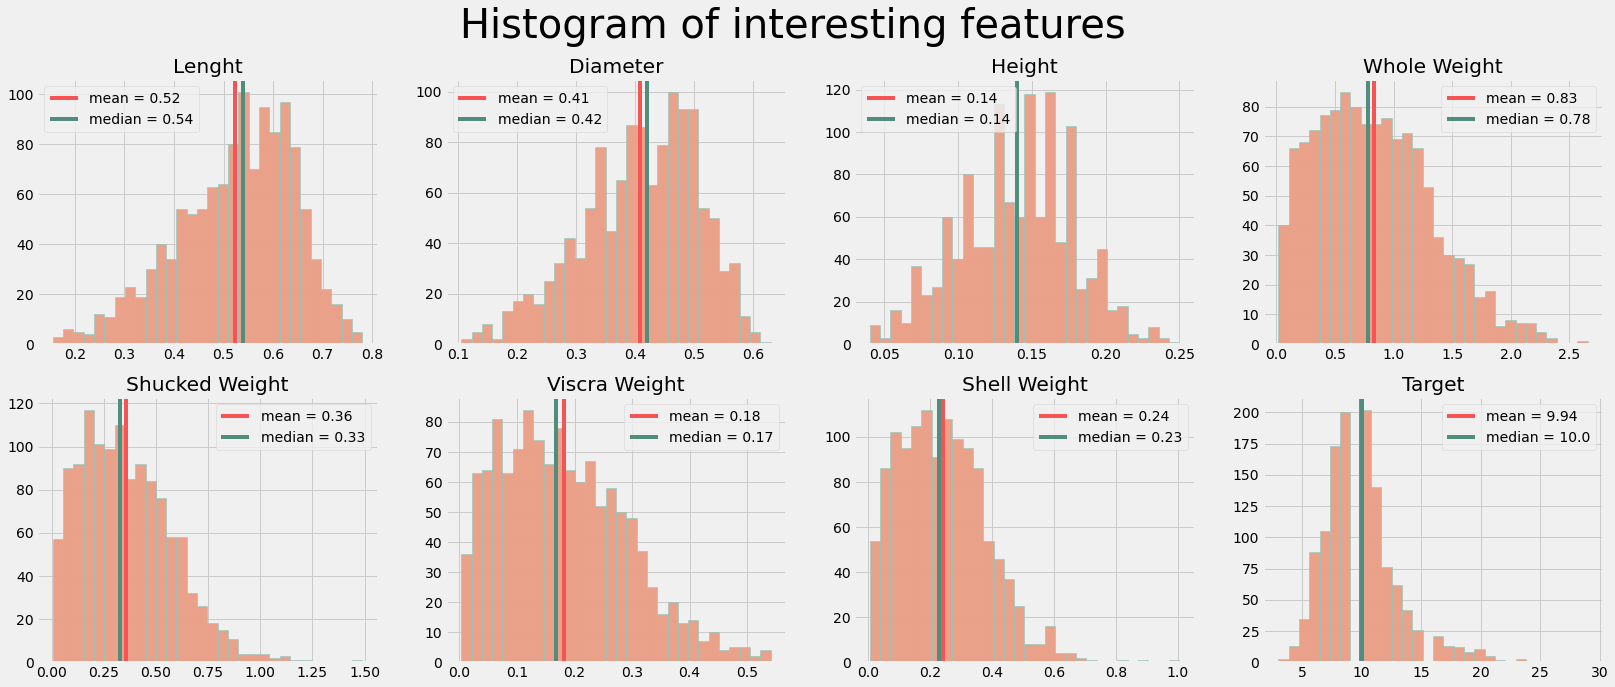

In [14]:
# 수치형 데이터 통계치 그래프
interest_coloumns = train.columns[1:]
plt.style.use('fivethirtyeight')
fig, ax =plt.subplots(2, 4, figsize = (25, 10))
fig.suptitle('Histogram of interesting features', fontsize=40)
column_idx = 0
for i in range(2):
    for j in range(4):
        ax[i][j].hist(train[interest_coloumns[column_idx]], bins=30, color='#eaa18a', edgecolor='#7bcabf')
        ax[i][j].set_title(interest_coloumns[column_idx])
        ax[i][j].axvline(data_description[interest_coloumns[column_idx]]['mean'], c='#f55354', label = f"mean = {round(data_description[interest_coloumns[column_idx]]['mean'], 2)}")
        ax[i][j].axvline(data_description[interest_coloumns[column_idx]]['50%'], c='#518d7d', label = f"median = {round(data_description[interest_coloumns[column_idx]]['50%'], 2)}")
        ax[i][j].legend()
        column_idx += 1

In [15]:
print('전복의 평균 나이는', round(data_description[interest_coloumns[7]]['mean'],1), '입니다') #round를 하여 소수점 1의 자리까지 반올림 하였습니다.

전복의 평균 나이는 9.9 입니다


Target을 보면 전복의 평균 나이는 약 9.9세라는 것을 알 수 있고

전복의 무게가 좌편향 되어있는 것을 보아

무게가 많이 나가는 전복들이 평균에 비하여 드물게 존재한다라는 인사이트를 얻을 수 있습니다.

### 타겟(나이)와 상관관계 확인하기

타겟인 나이와 나머지 변수들의 어떤 상관관계 있는지 확인 하기 위하여 

데이터를 이용하여 그래프를 그려보겠습니다.

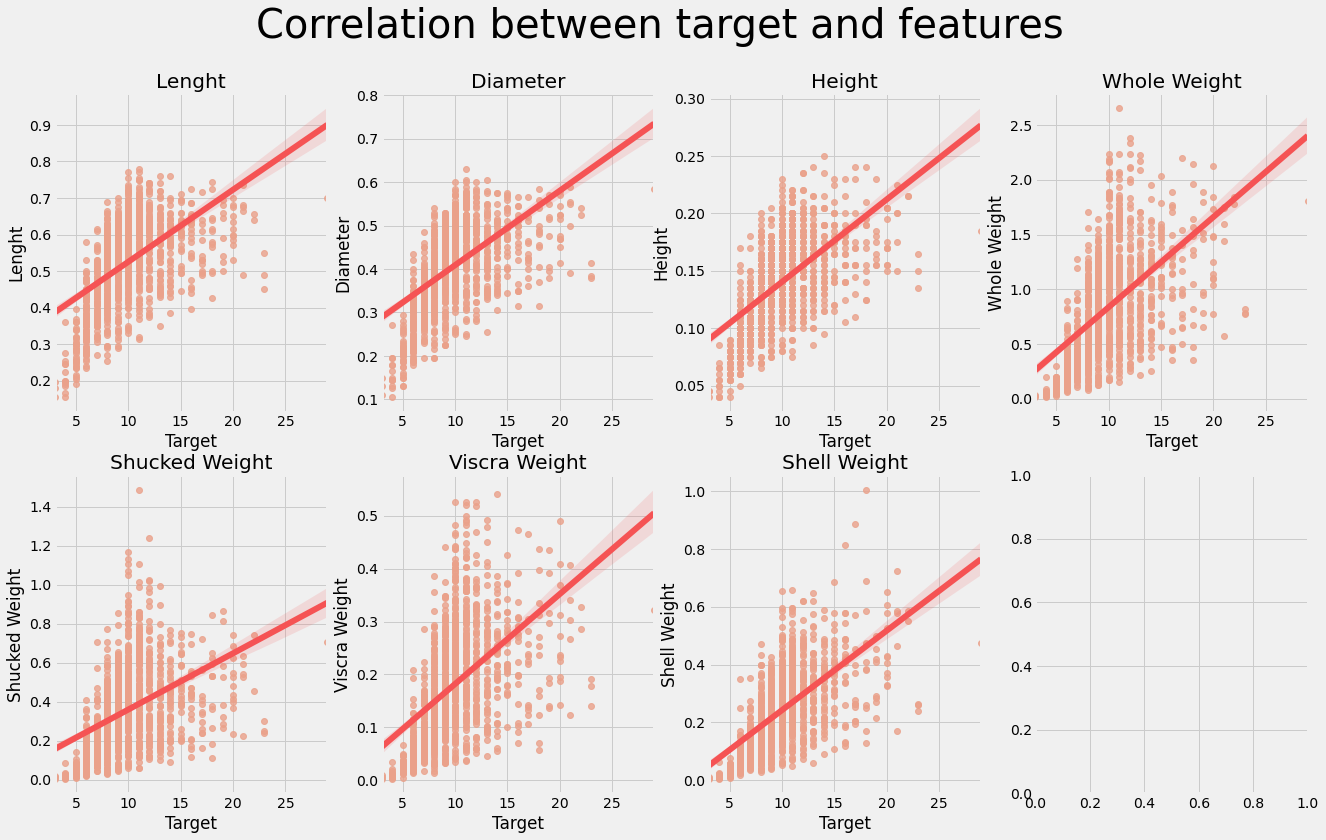

In [16]:
# 수치형 데이터 분포 Target과 상관관계 그래프
def visualize(axx, yfield):
  sns.regplot(x='Target', y=yfield, data=train,  color='#eaa18a', line_kws=  {'color': '#f55354'} , ax = axx) # regplot을 이용하여 추세선과 산점도 그래프를 그려줍니다.
  axx.set_title(yfield)

figure, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(nrows=2, ncols=4)
figure.set_size_inches(20,12)
figure.suptitle('Correlation between target and features', fontsize=40)
for i in range(len(train.columns[1:-1])):
  visualize(eval(f'ax{i+1}'), train.columns[i+1])

그래프를 통하여 Target(age)와 Lenght, Diameter, Height, Whole Weight, Sucked Weight, Wiscra Weight, Shell Weight 피쳐들 관계의 추세선을 확인해 보아,

모두 왼쪽 위 방향을 향하고 있으므로 양의 상관관계를 가지고 있음을 도출하였습니다.

### 히트맵 그려보기

피어슨 상관관계 분석 방법을 이용하여,

feature들 간의 상관관계를 히트맵을 그려 어떤 컬럼들이 높은 상관관계를 갖는지 알아보겠습니다.

In [17]:
# 수치형 데이터 상관관계 히트맵 시각화
train_corr = train.drop(columns=['Gender'],axis=1)
scaler= MinMaxScaler() 
train_corr[train_corr.columns] = scaler.fit_transform(train_corr[train_corr.columns])
corr28 = train_corr.corr(method= 'pearson')

Text(0.5, 1.0, 'Correlation between features')

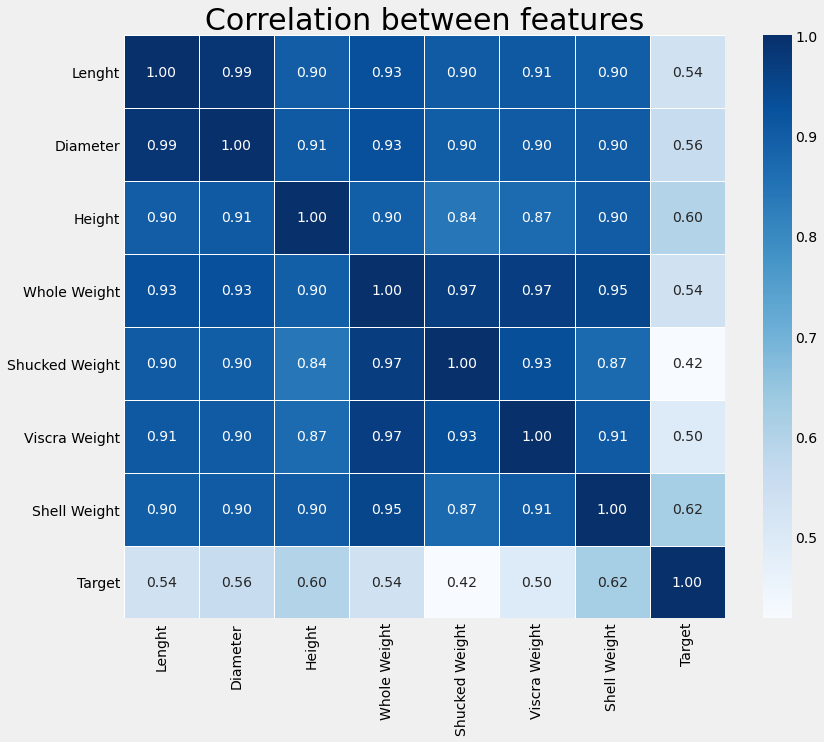

In [18]:
plt.figure(figsize=(12,10))
sns.heatmap(data = corr28, annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')
plt.title('Correlation between features', fontsize=30)

feature가 많아서 헷갈리니 Target과의 관계만을 살펴보겠습니다.



In [19]:
# Target과 피쳐들의 상관관계
s28 = corr28.unstack()
df_temp28 = pd.DataFrame(s28['Target'].sort_values(ascending=False), columns=['Target'])
df_temp28.style.background_gradient(cmap='viridis')

,Target
Target,1.000000
Shell Weight,0.622770
Height,0.598185
Diameter,0.560445
Whole Weight,0.535709
Lenght,0.535385
Viscra Weight,0.495420
Shucked Weight,0.418372


### 변수 합병

In [20]:
train["Length plus Diameter"] = train["Lenght"] + train["Diameter"]
test["Length plus Diameter"] = test["Lenght"] + test["Diameter"]

train["Viscra plus Shucked Weight"] = train["Viscra Weight"] + train["Shucked Weight"]
test["Viscra plus Shucked Weight"] = test["Viscra Weight"] + test["Shucked Weight"]

In [21]:
train["Length plus Whole Weight"] = train["Lenght"] + train["Whole Weight"]
test["Length plus Whole Weight"] = test["Lenght"] + test["Whole Weight"]

In [22]:
train["Shucked Weight plus Whole Weight"] = train["Shucked Weight"] + train["Whole Weight"]
test["Shucked Weight plus Whole Weight"] = test["Shucked Weight"] + test["Whole Weight"]

In [23]:
train["Height plus Shell Weight"] = train["Height"] + train["Shell Weight"]
test["Height plus Shell Weight"] = test["Height"] + test["Shell Weight"]

In [24]:
train["Height plus Diameter"] = train["Height"] + train["Diameter"]
test["Height plus Diameter"] = test["Height"] + test["Diameter"]

#### 변수 합병 후 히트맵 다시 그리기

In [25]:
# 수치형 데이터 상관관계 히트맵 시각화
train_corr = train.drop(columns=['Gender'],axis=1)
scaler= MinMaxScaler() 
train_corr[train_corr.columns] = scaler.fit_transform(train_corr[train_corr.columns])
corr28 = train_corr.corr(method= 'pearson')

Text(0.5, 1.0, 'Correlation between features')

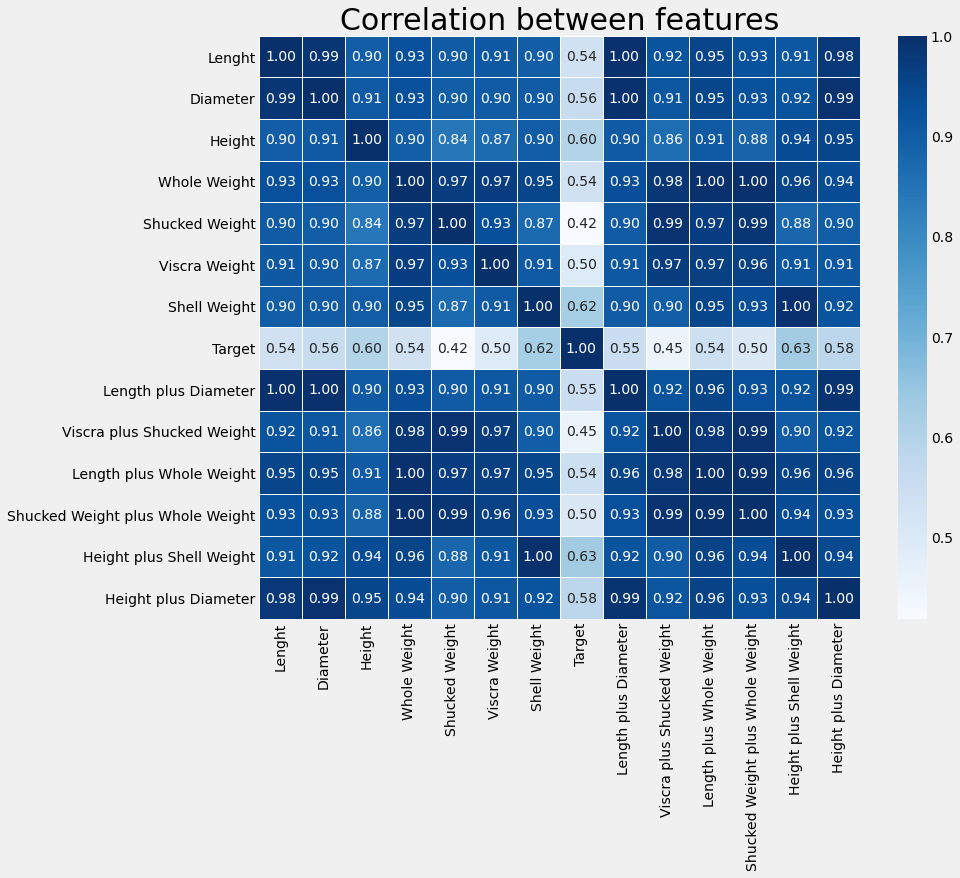

In [26]:
plt.figure(figsize=(12,10))
sns.heatmap(data = corr28, annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')
plt.title('Correlation between features', fontsize=30)

feature가 많아서 헷갈리니 Target과의 관계만을 살펴보겠습니다.



In [27]:
# Target과 피쳐들의 상관관계
s28 = corr28.unstack()
df_temp28 = pd.DataFrame(s28['Target'].sort_values(ascending=False), columns=['Target'])
df_temp28.style.background_gradient(cmap='viridis')

,Target
Target,1.000000
Height plus Shell Weight,0.628037
Shell Weight,0.622770
Height,0.598185
Height plus Diameter,0.582346
Diameter,0.560445
Length plus Diameter,0.548554
Length plus Whole Weight,0.541629
Whole Weight,0.535709
Lenght,0.535385


### 변수 선택

drop: 'Whole Weight', 'Lenght',  'Shucked Weight plus Whole Weight', 'Viscra Weight', 'Viscra plus Shucked Weight', 'Shucked Weight'

In [28]:
train = train.drop(columns=['Whole Weight', 'Lenght',  'Shucked Weight plus Whole Weight', 'Viscra Weight', 'Viscra plus Shucked Weight', 'Shucked Weight'],axis=1)
test = test.drop(columns=['Whole Weight', 'Lenght',  'Shucked Weight plus Whole Weight', 'Viscra Weight', 'Viscra plus Shucked Weight', 'Shucked Weight'],axis=1)

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1241 entries, 0 to 1240
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Gender                    1241 non-null   object 
 1   Diameter                  1241 non-null   float64
 2   Height                    1241 non-null   float64
 3   Shell Weight              1241 non-null   float64
 4   Target                    1241 non-null   int64  
 5   Length plus Diameter      1241 non-null   float64
 6   Length plus Whole Weight  1241 non-null   float64
 7   Height plus Shell Weight  1241 non-null   float64
 8   Height plus Diameter      1241 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 87.4+ KB


In [30]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2924 entries, 0 to 2923
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Gender                    2924 non-null   object 
 1   Diameter                  2924 non-null   float64
 2   Height                    2924 non-null   float64
 3   Shell Weight              2924 non-null   float64
 4   Length plus Diameter      2924 non-null   float64
 5   Length plus Whole Weight  2924 non-null   float64
 6   Height plus Shell Weight  2924 non-null   float64
 7   Height plus Diameter      2924 non-null   float64
dtypes: float64(7), object(1)
memory usage: 182.9+ KB


## 데이터 인코딩
머신러닝 알고리즘은 문자열 데이터 속성을 입력받지 않으며 모든 데이터는 숫자형으로 표현되어야 합니다.

그래서 문자형 카테고리형 속성은 모두 숫자 값으로 변환/인코딩 되어야 합니다.

우리 데이터에는 Gender라는 Feautre의 항목이 문자로 이루어져있기 때문에, 이것을 Encoding 해볼텐데요,

인코딩 방식에는 크게 'Label Encoding'과 'One-Hot Encoding'이 있습니다.

Label Encoding(범주형 변수의 문자열을 수치형으로 변환하는 방법)보다 One-Hot Encoding이 일반적으로 성능이 더 좋기 때문에 get_dummies 함수를 이용해 One-Hot Encoding을 사용해보겠습니다.

In [31]:
# convert to indicator values Gender
train = pd.get_dummies(train, columns = ['Gender'])
test = pd.get_dummies(test, columns = ['Gender'])

# pd.get_dummies: Convert categorical variable into dummy/indicator variables.

In [32]:
train.head()

,Diameter,Height,Shell Weight,Target,Length plus Diameter,Length plus Whole Weight,Height plus Shell Weight,Height plus Diameter,Gender_F,Gender_I,Gender_M
0,0.470,0.115,0.3100,15,1.075,1.7190,0.4250,0.585,0,0,1
1,0.315,0.095,0.1045,8,0.745,0.8080,0.1995,0.410,0,1,0
2,0.490,0.195,0.4100,18,1.070,1.8965,0.6050,0.685,0,1,0
3,0.405,0.175,0.3370,13,0.940,1.8055,0.5120,0.580,0,0,1
4,0.235,0.090,0.0400,6,0.545,0.4370,0.1300,0.325,0,1,0


In [33]:
test.head()

,Diameter,Height,Shell Weight,Length plus Diameter,Length plus Whole Weight,Height plus Shell Weight,Height plus Diameter,Gender_F,Gender_I,Gender_M
0,0.470,0.155,0.1550,1.065,1.716,0.3100,0.625,1,0,0
1,0.450,0.150,0.3600,1.030,1.507,0.5100,0.600,0,0,1
2,0.205,0.070,0.0305,0.465,0.357,0.1005,0.275,0,1,0
3,0.460,0.130,0.3300,1.050,1.692,0.4600,0.590,0,0,1
4,0.465,0.140,0.3050,1.060,1.708,0.4450,0.605,1,0,0


# 3. 모델 학습

본격적으로 모델 학습을 위해 학습 데이터와 Target을 분리합니다. 

In [34]:
X_train = train.drop(['Target'], axis=1)
y_train = train.Target

In [35]:
X_train.head()

,Diameter,Height,Shell Weight,Length plus Diameter,Length plus Whole Weight,Height plus Shell Weight,Height plus Diameter,Gender_F,Gender_I,Gender_M
0,0.470,0.115,0.3100,1.075,1.7190,0.4250,0.585,0,0,1
1,0.315,0.095,0.1045,0.745,0.8080,0.1995,0.410,0,1,0
2,0.490,0.195,0.4100,1.070,1.8965,0.6050,0.685,0,1,0
3,0.405,0.175,0.3370,0.940,1.8055,0.5120,0.580,0,0,1
4,0.235,0.090,0.0400,0.545,0.4370,0.1300,0.325,0,1,0


In [36]:
y_train.head()

0    15
1     8
2    18
3    13
4     6
Name: Target, dtype: int64

In [37]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor, VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from ngboost import NGBRegressor

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, learning_curve

In [38]:
def NMAE(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

In [39]:
random_state = 42

models = []
models.append(SVR())
models.append(DecisionTreeRegressor(random_state=random_state))
models.append(AdaBoostRegressor(random_state=random_state))
models.append(RandomForestRegressor(random_state=random_state))
models.append(ExtraTreesRegressor(random_state=random_state))
models.append(GradientBoostingRegressor(random_state=random_state))
models.append(MLPRegressor(random_state=random_state))
models.append(KNeighborsRegressor())
models.append(LinearRegression())
models.append(CatBoostRegressor())
models.append(XGBRegressor(random_state=random_state))
models.append(LGBMRegressor(random_state=random_state))
models.append(NGBRegressor(random_state=random_state))

In [40]:
for model in models:
    model.fit(X_train, y_train)

C:\Users\MOK\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Learning rate set to 0.042364
0:	learn: 3.1534532	total: 150ms	remaining: 2m 29s
1:	learn: 3.1063539	total: 152ms	remaining: 1m 15s
2:	learn: 3.0644192	total: 153ms	remaining: 51s
3:	learn: 3.0237064	total: 155ms	remaining: 38.6s
4:	learn: 2.9854847	total: 156ms	remaining: 31.1s
5:	learn: 2.9477794	total: 158ms	remaining: 26.2s
6:	learn: 2.9141029	total: 159ms	remaining: 22.6s
7:	learn: 2.8825494	total: 161ms	remaining: 19.9s
8:	learn: 2.8512836	total: 162ms	remaining: 17.9s
9:	learn: 2.8206726	total: 164ms	remaining: 16.2s
10:	learn: 2.7921937	total: 166ms	remaining: 14.9s
11:	learn: 2.7671334	total: 168ms	remaining: 13.8s
12:	learn: 2.7442753	total: 170ms	remaining: 12.9s
13:	learn: 2.7203642	total: 171ms	remaining: 12.1s
14:	learn: 2.6972365	total: 173ms	remaining: 11.4s
15:	learn: 2.6768558	total: 175ms	remaining: 10.8s
16:	learn: 2.6584004	total: 178ms	remaining: 10.3s
17:	learn: 2.6421780	total: 179ms	remaining: 9.77s
18:	learn: 2.6227584	total: 180ms	remaining: 9.31s
19:	learn: 

244:	learn: 1.9137146	total: 486ms	remaining: 1.5s
245:	learn: 1.9130981	total: 488ms	remaining: 1.49s
246:	learn: 1.9113329	total: 489ms	remaining: 1.49s
247:	learn: 1.9075460	total: 490ms	remaining: 1.49s
248:	learn: 1.9062319	total: 492ms	remaining: 1.48s
249:	learn: 1.9034018	total: 493ms	remaining: 1.48s
250:	learn: 1.9026406	total: 495ms	remaining: 1.48s
251:	learn: 1.8996258	total: 496ms	remaining: 1.47s
252:	learn: 1.8972761	total: 498ms	remaining: 1.47s
253:	learn: 1.8945633	total: 499ms	remaining: 1.47s
254:	learn: 1.8924375	total: 500ms	remaining: 1.46s
255:	learn: 1.8894070	total: 502ms	remaining: 1.46s
256:	learn: 1.8884977	total: 503ms	remaining: 1.45s
257:	learn: 1.8856019	total: 504ms	remaining: 1.45s
258:	learn: 1.8833091	total: 506ms	remaining: 1.45s
259:	learn: 1.8824249	total: 509ms	remaining: 1.45s
260:	learn: 1.8799139	total: 511ms	remaining: 1.45s
261:	learn: 1.8777681	total: 512ms	remaining: 1.44s
262:	learn: 1.8752559	total: 514ms	remaining: 1.44s
263:	learn: 1

468:	learn: 1.6020587	total: 796ms	remaining: 902ms
469:	learn: 1.6015475	total: 798ms	remaining: 900ms
470:	learn: 1.6001650	total: 799ms	remaining: 898ms
471:	learn: 1.5998541	total: 801ms	remaining: 895ms
472:	learn: 1.5987267	total: 802ms	remaining: 893ms
473:	learn: 1.5980416	total: 803ms	remaining: 891ms
474:	learn: 1.5967020	total: 805ms	remaining: 889ms
475:	learn: 1.5942474	total: 806ms	remaining: 887ms
476:	learn: 1.5928989	total: 807ms	remaining: 885ms
477:	learn: 1.5925045	total: 809ms	remaining: 883ms
478:	learn: 1.5919765	total: 810ms	remaining: 881ms
479:	learn: 1.5907913	total: 812ms	remaining: 880ms
480:	learn: 1.5906160	total: 814ms	remaining: 878ms
481:	learn: 1.5891287	total: 815ms	remaining: 876ms
482:	learn: 1.5879257	total: 817ms	remaining: 874ms
483:	learn: 1.5873853	total: 818ms	remaining: 872ms
484:	learn: 1.5855018	total: 819ms	remaining: 870ms
485:	learn: 1.5850844	total: 820ms	remaining: 868ms
486:	learn: 1.5849347	total: 822ms	remaining: 865ms
487:	learn: 

701:	learn: 1.3951089	total: 1.11s	remaining: 472ms
702:	learn: 1.3943266	total: 1.11s	remaining: 471ms
703:	learn: 1.3931906	total: 1.11s	remaining: 469ms
704:	learn: 1.3919232	total: 1.12s	remaining: 467ms
705:	learn: 1.3904491	total: 1.12s	remaining: 466ms
706:	learn: 1.3897856	total: 1.12s	remaining: 464ms
707:	learn: 1.3893672	total: 1.12s	remaining: 463ms
708:	learn: 1.3891672	total: 1.12s	remaining: 461ms
709:	learn: 1.3876238	total: 1.13s	remaining: 460ms
710:	learn: 1.3874467	total: 1.13s	remaining: 458ms
711:	learn: 1.3862596	total: 1.13s	remaining: 456ms
712:	learn: 1.3859299	total: 1.13s	remaining: 455ms
713:	learn: 1.3852439	total: 1.13s	remaining: 453ms
714:	learn: 1.3852136	total: 1.13s	remaining: 452ms
715:	learn: 1.3841267	total: 1.13s	remaining: 450ms
716:	learn: 1.3832229	total: 1.14s	remaining: 448ms
717:	learn: 1.3830440	total: 1.14s	remaining: 447ms
718:	learn: 1.3823365	total: 1.14s	remaining: 445ms
719:	learn: 1.3813978	total: 1.14s	remaining: 443ms
720:	learn: 

902:	learn: 1.2716538	total: 1.43s	remaining: 153ms
903:	learn: 1.2701216	total: 1.43s	remaining: 152ms
904:	learn: 1.2687130	total: 1.43s	remaining: 150ms
905:	learn: 1.2686315	total: 1.43s	remaining: 149ms
906:	learn: 1.2682874	total: 1.43s	remaining: 147ms
907:	learn: 1.2682626	total: 1.43s	remaining: 145ms
908:	learn: 1.2678786	total: 1.44s	remaining: 144ms
909:	learn: 1.2672104	total: 1.44s	remaining: 142ms
910:	learn: 1.2664677	total: 1.44s	remaining: 141ms
911:	learn: 1.2663285	total: 1.44s	remaining: 139ms
912:	learn: 1.2656081	total: 1.44s	remaining: 137ms
913:	learn: 1.2644123	total: 1.44s	remaining: 136ms
914:	learn: 1.2635621	total: 1.44s	remaining: 134ms
915:	learn: 1.2633673	total: 1.45s	remaining: 133ms
916:	learn: 1.2622103	total: 1.45s	remaining: 131ms
917:	learn: 1.2619979	total: 1.45s	remaining: 129ms
918:	learn: 1.2613914	total: 1.45s	remaining: 128ms
919:	learn: 1.2613195	total: 1.45s	remaining: 126ms
920:	learn: 1.2609540	total: 1.45s	remaining: 125ms
921:	learn: 

In [41]:
select = []

for model in models:
    y_pred = model.predict(X_train)
    print(model, "\n->", NMAE(y_train, y_pred))
    if (NMAE(y_train, y_pred) < 0.1):
        select.append(model)
        
print()
for model in select:
    print(model)

SVR() 
-> 0.1634392246125351
DecisionTreeRegressor(random_state=42) 
-> 0.0
AdaBoostRegressor(random_state=42) 
-> 0.2122275521389215
RandomForestRegressor(random_state=42) 
-> 0.06333306301192121
ExtraTreesRegressor(random_state=42) 
-> 0.0
GradientBoostingRegressor(random_state=42) 
-> 0.13077454698281413
MLPRegressor(random_state=42) 
-> 0.17822157806830413
KNeighborsRegressor() 
-> 0.14029681291055088
LinearRegression() 
-> 0.16592292674676182
-> 0.0921166361187616
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method

AdaBoostRegressor, RandomForestRegressor, XGBRegressor, LGBMRegressor, CatboostRegressor

In [42]:
dt_reg_best = DecisionTreeRegressor(max_depth=4, random_state=42)

mlp_reg_best = MLPRegressor(hidden_layer_sizes=(120, 80, 40), max_iter=100, random_state=42)

knn_reg_best = KNeighborsRegressor(n_neighbors=12)

ada_best = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5,
                                                       random_state=42),
                  learning_rate=0.001, n_estimators=9, random_state=42)
ExtR_best = ExtraTreesRegressor(max_features=10, min_samples_leaf=3, min_samples_split=10,
                    n_estimators=300)

RFR_best = RandomForestRegressor(bootstrap=False, max_depth=7, max_features=3,
                      min_samples_leaf=10, min_samples_split=10,
                      n_estimators=300)
GBR_best = GradientBoostingRegressor(learning_rate=0.05, max_depth=8, max_features=0.3,
                          min_samples_leaf=100, n_estimators=200)
SVMR_best = SVR(C=1000, gamma=0.1)

cbr_reg_best = CatBoostRegressor(iterations=1000, learning_rate=0.001, depth=6)

xgb_reg_best= XGBRegressor(n_estimators=500, learning_rate=0.01, max_depth=4)

lgbm_reg_best = LGBMRegressor(learning_rate=0.01, max_depth=6, n_estimators=500,
              random_state=42)

ngb_reg_best = NGBRegressor(Base=DecisionTreeRegressor(criterion='friedman_mse', max_depth=4),
             random_state=random_state)

In [43]:
#모델들을 할당할 리스트를 만들어줍니다.
models2 = []

#모델들을 각각 할당하여 리스트에 추가합니다.
models2.append(SVMR_best)
models2.append(dt_reg_best)
models2.append(ada_best)
models2.append(RFR_best)
models2.append(ExtR_best)
models2.append(GBR_best)
models2.append(mlp_reg_best)
models2.append(knn_reg_best)
models2.append(cbr_reg_best)
models2.append(xgb_reg_best)
models2.append(lgbm_reg_best)
models2.append(ngb_reg_best)

In [44]:
for model in models2:
    model.fit(X_train, y_train)

C:\Users\MOK\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


0:	learn: 3.2008692	total: 3.45ms	remaining: 3.44s
1:	learn: 3.1997583	total: 5.91ms	remaining: 2.95s
2:	learn: 3.1986546	total: 8.25ms	remaining: 2.74s
3:	learn: 3.1975718	total: 10.4ms	remaining: 2.58s
4:	learn: 3.1964216	total: 12.2ms	remaining: 2.42s
5:	learn: 3.1952379	total: 29.4ms	remaining: 4.87s
6:	learn: 3.1940941	total: 33.9ms	remaining: 4.81s
7:	learn: 3.1929502	total: 37.3ms	remaining: 4.63s
8:	learn: 3.1918073	total: 40.5ms	remaining: 4.46s
9:	learn: 3.1906227	total: 43ms	remaining: 4.25s
10:	learn: 3.1894207	total: 45.2ms	remaining: 4.06s
11:	learn: 3.1882443	total: 47ms	remaining: 3.87s
12:	learn: 3.1871372	total: 48.8ms	remaining: 3.7s
13:	learn: 3.1859827	total: 50.3ms	remaining: 3.54s
14:	learn: 3.1847865	total: 51.8ms	remaining: 3.4s
15:	learn: 3.1836224	total: 53.4ms	remaining: 3.28s
16:	learn: 3.1824395	total: 54.8ms	remaining: 3.17s
17:	learn: 3.1812996	total: 56.2ms	remaining: 3.06s
18:	learn: 3.1800303	total: 57.7ms	remaining: 2.98s
19:	learn: 3.1789156	total: 

171:	learn: 3.0237411	total: 323ms	remaining: 1.55s
172:	learn: 3.0228449	total: 325ms	remaining: 1.55s
173:	learn: 3.0219589	total: 327ms	remaining: 1.55s
174:	learn: 3.0210470	total: 329ms	remaining: 1.55s
175:	learn: 3.0200915	total: 331ms	remaining: 1.55s
176:	learn: 3.0191706	total: 333ms	remaining: 1.55s
177:	learn: 3.0182980	total: 335ms	remaining: 1.55s
178:	learn: 3.0174470	total: 337ms	remaining: 1.55s
179:	learn: 3.0164918	total: 339ms	remaining: 1.54s
180:	learn: 3.0155496	total: 341ms	remaining: 1.54s
181:	learn: 3.0146150	total: 343ms	remaining: 1.54s
182:	learn: 3.0137235	total: 345ms	remaining: 1.54s
183:	learn: 3.0127814	total: 347ms	remaining: 1.54s
184:	learn: 3.0118262	total: 349ms	remaining: 1.53s
185:	learn: 3.0109339	total: 351ms	remaining: 1.53s
186:	learn: 3.0100777	total: 353ms	remaining: 1.53s
187:	learn: 3.0091813	total: 356ms	remaining: 1.54s
188:	learn: 3.0082354	total: 359ms	remaining: 1.54s
189:	learn: 3.0072995	total: 361ms	remaining: 1.54s
190:	learn: 

333:	learn: 2.8900384	total: 637ms	remaining: 1.27s
334:	learn: 2.8892462	total: 639ms	remaining: 1.27s
335:	learn: 2.8884882	total: 641ms	remaining: 1.27s
336:	learn: 2.8877829	total: 643ms	remaining: 1.26s
337:	learn: 2.8870220	total: 644ms	remaining: 1.26s
338:	learn: 2.8862756	total: 646ms	remaining: 1.26s
339:	learn: 2.8855176	total: 648ms	remaining: 1.26s
340:	learn: 2.8847049	total: 650ms	remaining: 1.26s
341:	learn: 2.8840608	total: 652ms	remaining: 1.25s
342:	learn: 2.8834231	total: 655ms	remaining: 1.25s
343:	learn: 2.8826237	total: 657ms	remaining: 1.25s
344:	learn: 2.8819149	total: 659ms	remaining: 1.25s
345:	learn: 2.8812027	total: 661ms	remaining: 1.25s
346:	learn: 2.8804540	total: 663ms	remaining: 1.25s
347:	learn: 2.8797196	total: 665ms	remaining: 1.25s
348:	learn: 2.8789849	total: 667ms	remaining: 1.24s
349:	learn: 2.8783130	total: 669ms	remaining: 1.24s
350:	learn: 2.8775776	total: 671ms	remaining: 1.24s
351:	learn: 2.8769169	total: 673ms	remaining: 1.24s
352:	learn: 

493:	learn: 2.7843616	total: 953ms	remaining: 976ms
494:	learn: 2.7837441	total: 955ms	remaining: 975ms
495:	learn: 2.7831339	total: 957ms	remaining: 973ms
496:	learn: 2.7825219	total: 960ms	remaining: 971ms
497:	learn: 2.7818808	total: 964ms	remaining: 972ms
498:	learn: 2.7813040	total: 966ms	remaining: 970ms
499:	learn: 2.7806452	total: 968ms	remaining: 968ms
500:	learn: 2.7800306	total: 971ms	remaining: 967ms
501:	learn: 2.7794651	total: 974ms	remaining: 966ms
502:	learn: 2.7788875	total: 977ms	remaining: 965ms
503:	learn: 2.7782861	total: 980ms	remaining: 964ms
504:	learn: 2.7776370	total: 982ms	remaining: 962ms
505:	learn: 2.7770432	total: 984ms	remaining: 960ms
506:	learn: 2.7764995	total: 986ms	remaining: 958ms
507:	learn: 2.7758779	total: 988ms	remaining: 957ms
508:	learn: 2.7752866	total: 990ms	remaining: 955ms
509:	learn: 2.7747008	total: 992ms	remaining: 953ms
510:	learn: 2.7741282	total: 994ms	remaining: 951ms
511:	learn: 2.7735267	total: 996ms	remaining: 949ms
512:	learn: 

713:	learn: 2.6708173	total: 1.43s	remaining: 571ms
714:	learn: 2.6703644	total: 1.43s	remaining: 569ms
715:	learn: 2.6698856	total: 1.43s	remaining: 567ms
716:	learn: 2.6694571	total: 1.43s	remaining: 566ms
717:	learn: 2.6690342	total: 1.44s	remaining: 564ms
718:	learn: 2.6685880	total: 1.44s	remaining: 563ms
719:	learn: 2.6681090	total: 1.44s	remaining: 561ms
720:	learn: 2.6677156	total: 1.44s	remaining: 559ms
721:	learn: 2.6672788	total: 1.45s	remaining: 557ms
722:	learn: 2.6668230	total: 1.45s	remaining: 555ms
723:	learn: 2.6663875	total: 1.45s	remaining: 553ms
724:	learn: 2.6658979	total: 1.45s	remaining: 551ms
725:	learn: 2.6654544	total: 1.46s	remaining: 550ms
726:	learn: 2.6650378	total: 1.46s	remaining: 548ms
727:	learn: 2.6646040	total: 1.46s	remaining: 546ms
728:	learn: 2.6641431	total: 1.46s	remaining: 544ms
729:	learn: 2.6636679	total: 1.47s	remaining: 542ms
730:	learn: 2.6632088	total: 1.47s	remaining: 540ms
731:	learn: 2.6627567	total: 1.47s	remaining: 538ms
732:	learn: 

875:	learn: 2.6063333	total: 1.74s	remaining: 246ms
876:	learn: 2.6059963	total: 1.74s	remaining: 244ms
877:	learn: 2.6056551	total: 1.75s	remaining: 242ms
878:	learn: 2.6053437	total: 1.75s	remaining: 241ms
879:	learn: 2.6049818	total: 1.75s	remaining: 239ms
880:	learn: 2.6045941	total: 1.75s	remaining: 237ms
881:	learn: 2.6042431	total: 1.75s	remaining: 235ms
882:	learn: 2.6038066	total: 1.75s	remaining: 233ms
883:	learn: 2.6033918	total: 1.76s	remaining: 231ms
884:	learn: 2.6030590	total: 1.76s	remaining: 229ms
885:	learn: 2.6026684	total: 1.76s	remaining: 227ms
886:	learn: 2.6023453	total: 1.76s	remaining: 225ms
887:	learn: 2.6019940	total: 1.77s	remaining: 223ms
888:	learn: 2.6016191	total: 1.77s	remaining: 221ms
889:	learn: 2.6011744	total: 1.77s	remaining: 219ms
890:	learn: 2.6007788	total: 1.77s	remaining: 217ms
891:	learn: 2.6004497	total: 1.77s	remaining: 215ms
892:	learn: 2.6001370	total: 1.77s	remaining: 213ms
893:	learn: 2.5997524	total: 1.78s	remaining: 211ms
894:	learn: 

In [45]:
select2 = []

for model in models2:
    y_pred = model.predict(X_train)
    print(model, "\n->", NMAE(y_train, y_pred))
    if (NMAE(y_train, y_pred) < 0.15):
        select2.append(model)
        
print()
for model in select2:
    print(model)

SVR(C=1000, gamma=0.1) 
-> 0.1512505848179667
DecisionTreeRegressor(max_depth=4, random_state=42) 
-> 0.16024472119066643
AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5,
                                                       random_state=42),
                  learning_rate=0.001, n_estimators=9, random_state=42) 
-> 0.15106197148271275
RandomForestRegressor(bootstrap=False, max_depth=7, max_features=3,
                      min_samples_leaf=10, min_samples_split=10,
                      n_estimators=300) 
-> 0.14113549253639376
ExtraTreesRegressor(max_features=10, min_samples_leaf=3, min_samples_split=10,
                    n_estimators=300) 
-> 0.11067575504216579
GradientBoostingRegressor(learning_rate=0.05, max_depth=8, max_features=0.3,
                          min_samples_leaf=100, n_estimators=200) 
-> 0.15315075592057312
MLPRegressor(hidden_layer_sizes=(120, 80, 40), max_iter=100, random_state=42) 
-> 0.15786918017352455
KNeighborsRegressor(n_neighbors=12

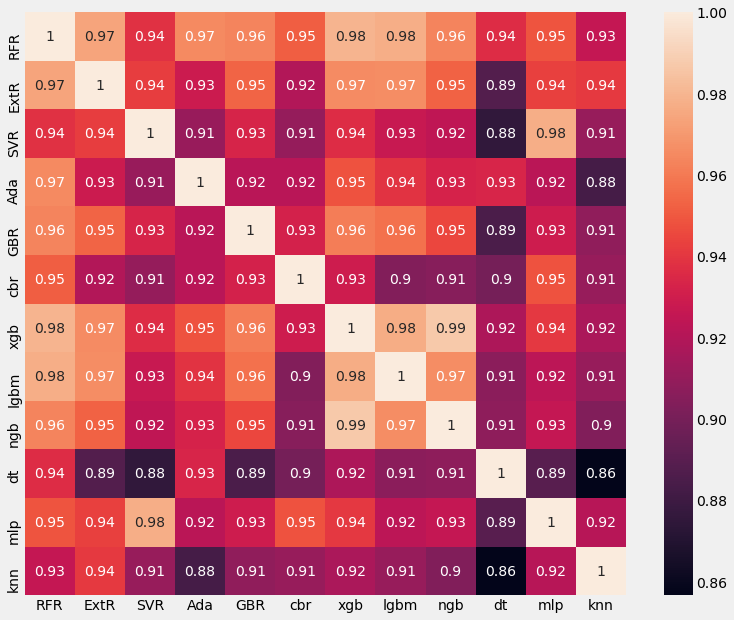

In [48]:
test_Survived_RFR = pd.Series(RFR_best.predict(test), name="RFR")
test_Survived_ExtR = pd.Series(ExtR_best.predict(test), name="ExtR")
test_Survived_SVMR = pd.Series(SVMR_best.predict(test), name="SVR")
test_Survived_AdaR = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBR = pd.Series(GBR_best.predict(test), name="GBR")

test_Survived_cbr = pd.Series(cbr_reg_best.predict(test), name="cbr")
test_Survived_xgb = pd.Series(xgb_reg_best.predict(test), name="xgb")
test_Survived_lgbm = pd.Series(lgbm_reg_best.predict(test), name="lgbm")
test_Survived_ngb = pd.Series(ngb_reg_best.predict(test), name="ngb")

test_Survived_dt = pd.Series(dt_reg_best.predict(test), name="dt")
test_Survived_mlp = pd.Series(mlp_reg_best.predict(test), name="mlp")
test_Survived_knn = pd.Series(knn_reg_best.predict(test), name="knn")

survived_list = [test_Survived_RFR, test_Survived_ExtR, test_Survived_SVMR, test_Survived_AdaR, test_Survived_GBR,
            test_Survived_cbr,test_Survived_xgb,test_Survived_lgbm,test_Survived_ngb,
           test_Survived_dt, test_Survived_mlp, test_Survived_knn]

# Concatenate all classifier results
#ensemble_results = pd.concat([test_Survived_cbr,test_Survived_xgb,test_Survived_lgbm,test_Survived_ngb],axis=1)
ensemble_results = pd.concat(survived_list,axis=1)

plt.figure(figsize=(12,10))
g= sns.heatmap(ensemble_results.corr(),annot=True)

In [94]:
estimators=[('rfr', RFR_best), ('extr', ExtR_best), ('svr', SVMR_best), 
                ('adar',ada_best),('gbr',GBR_best),
            ('cbr', cbr_reg_best), ('xgb', xgb_reg_best), ('lgbm', lgbm_reg_best),
            ('mlp',mlp_reg_best)]

voting_reg = VotingRegressor(estimators = estimators, n_jobs=-1)

voting_reg = voting_reg.fit(X_train, y_train)

In [95]:
from sklearn.metrics import mean_absolute_error

In [96]:
y_pred = voting_reg.predict(X_train)
print("\nmae", mean_absolute_error(y_train, y_pred))
print("nmae", NMAE(y_train, y_pred))


mae 1.399920511907366
nmae 0.1408889267112999


In [61]:
# 비교
for model in models2:    
    y_pred = model.predict(X_train)
    print(model, "\nmae", mean_absolute_error(y_train, y_pred))
    print("nmae", NMAE(y_train, y_pred))
    
#rf, extra, xgb, lgb

SVR(C=1000, gamma=0.1) 
mae 1.5028774870188104
nmae 0.1512505848179667
DecisionTreeRegressor(max_depth=4, random_state=42) 
mae 1.5922462989541608
nmae 0.16024472119066643
AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5,
                                                       random_state=42),
                  learning_rate=0.001, n_estimators=9, random_state=42) 
mae 1.5010033604781106
nmae 0.15106197148271275
RandomForestRegressor(bootstrap=False, max_depth=7, max_features=3,
                      min_samples_leaf=10, min_samples_split=10,
                      n_estimators=300) 
mae 1.4023704741871674
nmae 0.14113549253639376
ExtraTreesRegressor(max_features=10, min_samples_leaf=3, min_samples_split=10,
                    n_estimators=300) 
mae 1.099712115572076
nmae 0.11067575504216579
GradientBoostingRegressor(learning_rate=0.05, max_depth=8, max_features=0.3,
                          min_samples_leaf=100, n_estimators=200) 
mae 1.5217582363066764
nmae 0.15315

In [97]:
test_Survived = pd.Series(voting_reg.predict(test), name="Survived")

test_Survived

0        8.278227
1       12.291925
2        5.745197
3       11.193242
4       10.488056
          ...    
2919     4.313290
2920     7.748372
2921     9.589186
2922     9.399686
2923    11.650733
Name: Survived, Length: 2924, dtype: float64

In [98]:
# 제출용 Sample 파일을 불러옵니다
submission = pd.read_csv('data/sample_submission.csv')
submission.head()

,id,Target
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [99]:
submission['Target'] = test_Survived

# 데이터가 잘 들어갔는지 확인합니다
submission

,id,Target
0,1,8.278227
1,2,12.291925
2,3,5.745197
3,4,11.193242
4,5,10.488056
...,...,...
2919,2920,4.313290
2920,2921,7.748372
2921,2922,9.589186
2922,2923,9.399686


In [100]:
submission.to_csv('data/submission_voting_final2.csv', index=False)